In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from experiment_utils import *
from src import *
import numpy as np



pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [2]:
def plot_baf(preds, preds_base, X, y, title, sensitive_attrs):
    """
    plot scatter of preds vs preds_base.
    color points based on combinations of sensitive attributes in X, with names of the sens columns given in sensitive_attrs.
    """
    fig, ax = plt.subplots()
    
    # Create unique combinations of sensitive attributes
    unique_combinations = np.unique(X[sensitive_attrs].to_numpy(), axis=0)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_combinations*2)))
    color_dict = {tuple(combination): color for combination, color in zip(unique_combinations, colors)}
    
        
    # Create unique combinations of sensitive attributes
    unique_combinations = np.unique(X[sensitive_attrs].to_numpy(), axis=0)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_combinations)*2))    
    color_dict = {}
    for i, combo in enumerate(unique_combinations):
        color_dict[tuple(combo)] = colors[i*2:(i+1)*2]
    
    print(colors) 
    print(color_dict)
    
    # Add lines at x and y axes
    ax.axhline(0.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(0.5, color='black', linestyle='--', linewidth=1)
    
    label_mask = (y == 1)
    # Scatter plot with color based on combinations of sensitive attributes
    for combination in unique_combinations:
        mask = np.all(X[sensitive_attrs].to_numpy() == combination, axis=1)
        ax.scatter(preds_base[mask & label_mask], preds[mask & label_mask], label=str(combination), color=color_dict[tuple(combination)][0], marker='s', alpha=0.5, s=20, edgecolor='none')
        ax.scatter(preds_base[mask & ~label_mask], preds[mask & ~label_mask], label=str(combination), color=color_dict[tuple(combination)][1], alpha=0.5, s=20, edgecolor='none')
    
    # Add labels and title
    ax.set_xlabel('Predictions Base Model')
    ax.set_ylabel('Predictions Model')
    ax.set_title(title)
    
    # Add legend
    ax.legend(title=sensitive_attrs)
    
    plt.show()


Compas Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 10
{(0.0, 1.0): 0.07918342097123415, (1.0, 0.0): 0.5467058459635014, (1.0, 1.0): 0.2596659449427776, (0.0, 0.0): 0.11444478812248686}
{(0.0, 1.0): 0.07918342097123415, (1.0, 0.0): 0.5467058459635014, (1.0, 1.0): 0.2596659449427776, (0.0, 0.0): 0.11444478812248686}
DISCR LAYERS [8, 30, 30]
DISCR LAYERS [8, 30, 30]
[[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]
{(0.0, 0.0): array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.275191, 0.194905, 0.496005, 1.      ]]), (0

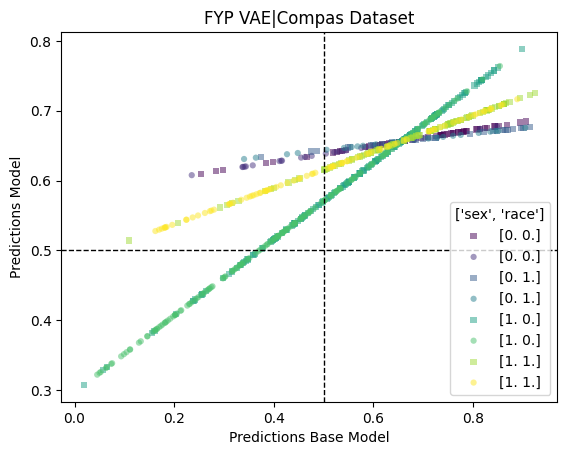

In [3]:

comment= "dont mask same to same"

epochs = 1300
results_filename = "BAF_mod"
other = {}
datasets = [Tester.ADULT_D, Tester.COMPAS_D] #[Tester.ADULT_D,  Tester.COMPAS_D]#, Tester.GERMAN_D, Tester.ADULT_D,], Tester.COMPAS_D, 
latent_dims = [25, 12]
metric_names = [Metrics.ACC, Metrics.SF]
losses = [[VAEMaskConfig.LATENT_S_ADV_LOSS, VAEMaskConfig.POS_VECTOR_LOSS,        VAEMaskConfig.RECON_LOSS, VAEMaskConfig.KL_DIV_LOSS]]

for dataset, dim in zip(datasets, latent_dims):
    for s in [["sex","race"]]: #  ["sex","race"],["race"],["sex"]
        print("="*100)
        print(dataset, s)

        mls = [
            TestConfig(Tester.FYP_VAE, Model.MLP_C, sensitive_attr=s, other={"c": comment, VAEMaskModel.VAE_MASK_CONFIG:  
                VAEMaskConfig(epochs=epochs, latent_dim=dim, lr=0.014, losses_used=l)}) for l in losses
            ]
        base = TestConfig(Tester.BASE_ML, Model.MLP_C , sensitive_attr = s)
        results_file = os.path.join("results",results_filename +"_".join(s)+".csv")
        tester = Tester(results_file, dataset, metric_names)
        for ml in mls:
            print("-"*100)
            print(ml.bias_mit)
            tester.run_tests([ml, base], 1, save_intermid_results=True)
            preds, X, y = tester.get_last_run()
            
            plot_baf(preds[0], preds[1], X, y, ml.bias_mit + '|' + dataset, s)
            
        